In [3]:
from radar import RadarMesure
import matplotlib.pyplot as plt 
import glob
import pickle
import numpy as np

import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


# -------------------------
# Paramètres physiques
# -------------------------
c = 299792458  # vitesse de la lumière
pad_factor = 4

# RCS de la boule (valeur constante)
sigmacr_boule = 0.073  # m²

# -------------------------
# Fonctions utilitaires
# -------------------------
def bin_to_dist(x, pad_factor=1):
    """Convertit les indices de bins en distance (mètres)."""
    c = 299792458
    B = 2e9
    ramptime = 102400e-9
    fe = 10e6
    df = fe / 1024
    fb = x * df
    dist = fb * c * ramptime / (2 * B)
    return dist / pad_factor

def model(R, ccalib, sigma):
    """Modèle radar : intensité proportionnelle à σ/R⁴."""
    return ccalib * sigma / (R**4)

def extract_peaks(ri_list, seuil):
    """Extrait les pics et retourne (distance, intensité)."""
    pic = []
    for i in ri_list:
        df = i.df
        peaks, prop = find_peaks(df.copol.loc[1:5], height=seuil)
        if len(peaks) > 0:
            dist = bin_to_dist(peaks[0], pad_factor) + 1
            val = prop['peak_heights'][0]**2
            pic.append((dist, val))
    if not pic:
        return np.array([]), np.array([])
    dfpic = pd.DataFrame(pic).sort_values(by=[0])
    return np.asarray(dfpic[0]), np.asarray(dfpic[1])

def fit_and_evaluate(X, y, sigma, initial_guess=(1.9e-1,), bounds=([-1], [1])):
    """Fit indépendant (1 paramètre : c_calib) et calcul du R²."""
    popt, pcov = curve_fit(
        lambda R, c: model(R, c, sigma),
        X, y,
        p0=initial_guess,
        bounds=bounds
    )
    perr = np.sqrt(np.diag(pcov))
    y_pred = model(X, *popt, sigma)
    r2 = r2_score(y, y_pred)
    return popt, perr, y_pred, r2

# -------------------------
# Chargement des jeux
# -------------------------
data_boule_13 = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/calisphere/13*.txt')
data_boule_17 = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/calisphere/17*.txt')

data_boule_13.sort()
data_boule_17.sort()

def get_c(beta,pad_factor):
    ri_boule_13 = [RadarMesure(f, beta=beta, pad_factor=pad_factor ,calib = True) for f in data_boule_13]
    ri_boule_17 = [RadarMesure(f, beta=beta, pad_factor=pad_factor ,calib = True) for f in data_boule_17]

    # -------------------------
    # Extraction des pics
    # -------------------------
    X_13, y_13 = extract_peaks(ri_boule_13, seuil=0.005)
    X_17, y_17 = extract_peaks(ri_boule_17, seuil=0.001)

    if len(X_13) == 0 or len(X_17) == 0:
        raise RuntimeError("Erreur : un des jeux (13 GHz ou 17 GHz) ne contient pas de pics.")

    # -------------------------
    # Fit indépendants
    # -------------------------
    popt_13, perr_13, y_pred_13, r2_13 = fit_and_evaluate(X_13, y_13, sigmacr_boule)
    popt_17, perr_17, y_pred_17, r2_17 = fit_and_evaluate(X_17, y_17, sigmacr_boule)

    c13 = popt_13[0]
    c17 = popt_17[0]

    print(f"\n=== Résultats Fit Boule 13 GHz ===")
    print(f"  c_calib = {c13:.3e} ± {perr_13[0]:.1e}")
    print(f"  R²      = {r2_13:.4f}")

    print(f"\n=== Résultats Fit Boule 17 GHz ===")
    print(f"  c_calib = {c17:.3e} ± {perr_17[0]:.1e}")
    print(f"  R²      = {r2_17:.4f}")
    return(c13,c17)

def is_number(value):
        try:
            float(value)
            return True
        except (ValueError, TypeError):
            return False


with open ('20degdataset', 'rb') as fp:
    data = pickle.load(fp)

beta_list = [8]
pad_list = [4]

for pad_factor in pad_list :
    for beta in beta_list:
        print(beta,pad_factor)

        c13,c17 = get_c(beta,pad_factor)
        mesures = []

       # for f in data :
           # mesures.append(RadarMesure(f,beta,pad_factor))

        s13 = []
        s17 = []

        #for i in mesures:
            
            #if i.pente != None and is_number(i.angle_local): 
            #    if i.frequence == 17:
           #         sigma = RadarMesure.get_sigma0(i,c17)
           #         i.sigma = sigma
             #       s17.append(sigma[0])
            #    if i.frequence == 13:
             #       sigma = RadarMesure.get_sigma0(i,c13)
              #      i.sigma = sigma
              #      s13.append(sigma[0])

       # plt.hist(s13,bins = 30)
       # plt.title('13 GHz')
      #  plt.show()
      #  plt.hist(s17,bins = 30)
     #   plt.title('17 GHz')
      #  plt.show()


8 4

=== Résultats Fit Boule 13 GHz ===
  c_calib = 3.238e-01 ± 1.3e-02
  R²      = 0.9630

=== Résultats Fit Boule 17 GHz ===
  c_calib = 3.043e-03 ± 6.5e-05
  R²      = 0.9900


In [4]:
from itertools import groupby
from operator import itemgetter

with open('white_reference.pkl', 'rb') as f:
    white_refs = pickle.load(f)

white_13 = white_refs['13GHz']['mean']
white_17 = white_refs['17GHz']['mean']


def get_sigma0(self,c):

    angle_incident_local = (self.angle_local)-(self.pente)
    df = self.df.loc[0.5:]
    sigma_raw = (df['copol'] ** 2) * (df.index ** 4) / c
    air = self.get_air(angle_incident_local, df.index.values)
    delta_r = np.diff(df.index.values).mean()
    sigma = (sigma_raw / air) * delta_r

    sigma_cumsum_log = np.log10(np.cumsum(sigma.values))

    sigma_df = pd.DataFrame({
        'range': df.index.values,
        'sigma_log': sigma_cumsum_log,
    })

    return sigma_df

In [7]:
k = RadarMesure('../data/fm_on_snowpacks/F9/13GHz_altforest_0_v_30deg.txt',beta,pad_factor,compute=False)

In [15]:
print(k.time)

2025-03-01 15:17:24.546744


In [3]:
data = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/untest/*')
mesures = []
for f in data :
    mesures.append(RadarMesure(f,beta,pad_factor))

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_8_v_30deg.txt 14.3078756332397
(np.float64(-1.1195857927023933),           range  sigma_log
0      0.507055  -5.993102
1      0.525792  -5.973029
2      0.544529  -5.972218
3      0.563267  -5.972148
4      0.582004  -5.972127
...         ...        ...
2028  38.505749  -1.114789
2029  38.524487  -1.114789
2030  38.543224  -1.114789
2031  38.561961  -1.114789
2032  38.580698  -1.114789

[2033 rows x 2 columns])


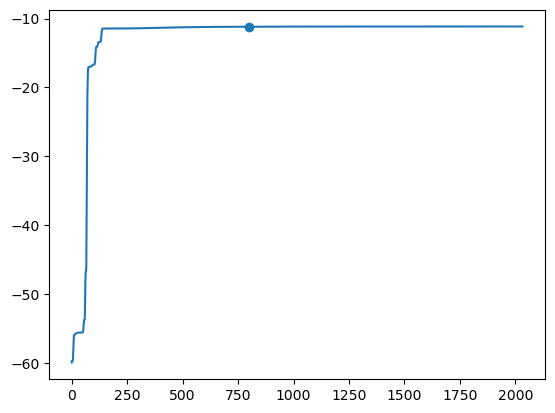

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_4_v_15deg.txt 14.3579883575439
(np.float64(-0.4181636466450313),           range  sigma_log
0      0.507055  -5.938811
1      0.525792  -5.919247
2      0.544529  -5.918544
3      0.563267  -5.918478
4      0.582004  -5.918455
...         ...        ...
2028  38.505749  -0.415969
2029  38.524487  -0.415969
2030  38.543224  -0.415969
2031  38.561961  -0.415969
2032  38.580698  -0.415969

[2033 rows x 2 columns])


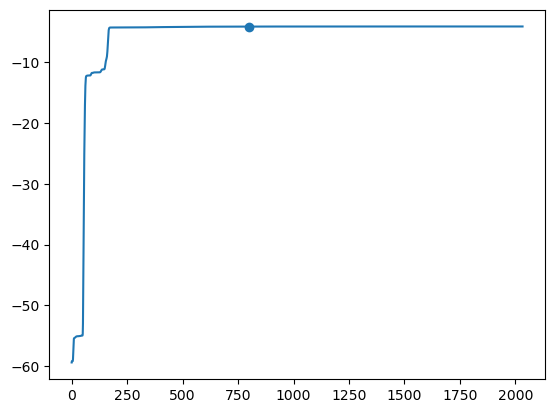

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_8_v_15deg.txt 14.3078756332397
(np.float64(-1.0836171835817008),           range  sigma_log
0      0.507055  -5.984266
1      0.525792  -5.965328
2      0.544529  -5.964624
3      0.563267  -5.964539
4      0.582004  -5.964532
...         ...        ...
2028  38.505749  -1.079878
2029  38.524487  -1.079877
2030  38.543224  -1.079877
2031  38.561961  -1.079877
2032  38.580698  -1.079877

[2033 rows x 2 columns])


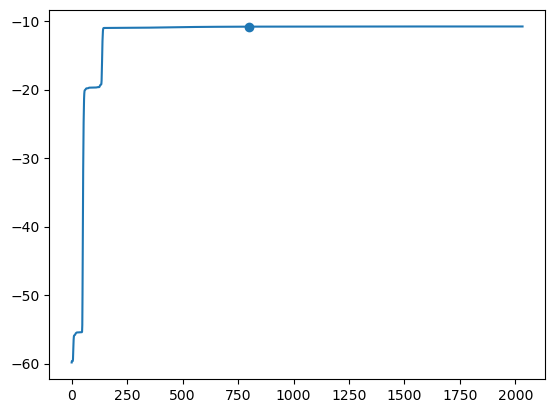

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_2_v_30deg.txt 6.17869091033936
(np.float64(-2.281761459422104),           range  sigma_log
0      0.507055  -5.954676
1      0.525792  -5.934838
2      0.544529  -5.934275
3      0.563267  -5.934257
4      0.582004  -5.934196
...         ...        ...
2028  38.505749  -2.253971
2029  38.524487  -2.253969
2030  38.543224  -2.253967
2031  38.561961  -2.253965
2032  38.580698  -2.253963

[2033 rows x 2 columns])


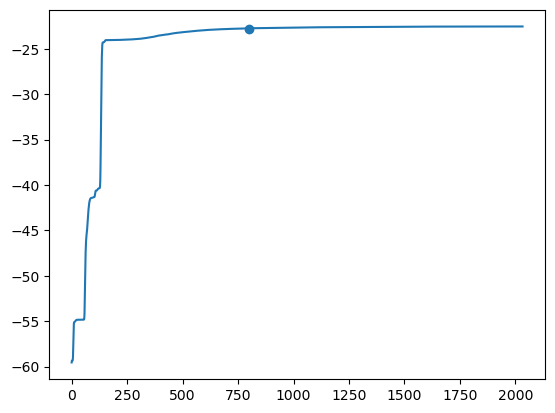

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_3_v_30deg.txt 9.85938739776611
(np.float64(-2.619387175276977),           range  sigma_log
0      0.507055  -5.951209
1      0.525792  -5.930970
2      0.544529  -5.930178
3      0.563267  -5.930117
4      0.582004  -5.930100
...         ...        ...
2028  38.505749  -2.562257
2029  38.524487  -2.562253
2030  38.543224  -2.562248
2031  38.561961  -2.562243
2032  38.580698  -2.562238

[2033 rows x 2 columns])


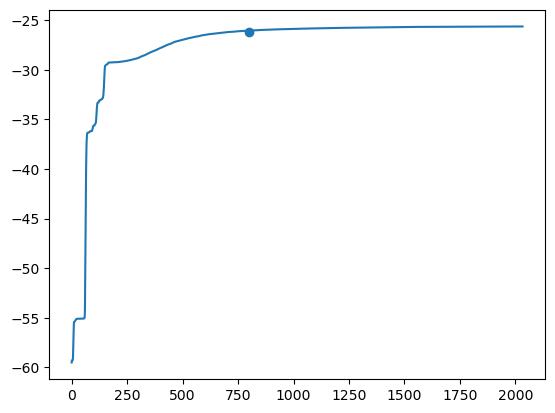

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_7_v_-15deg.txt 16.1153011322021
(np.float64(-2.3821197100589084),           range  sigma_log
0      0.507055  -5.987162
1      0.525792  -5.964966
2      0.544529  -5.963999
3      0.563267  -5.963939
4      0.582004  -5.963924
...         ...        ...
2028  38.505749  -2.352734
2029  38.524487  -2.352732
2030  38.543224  -2.352729
2031  38.561961  -2.352727
2032  38.580698  -2.352724

[2033 rows x 2 columns])


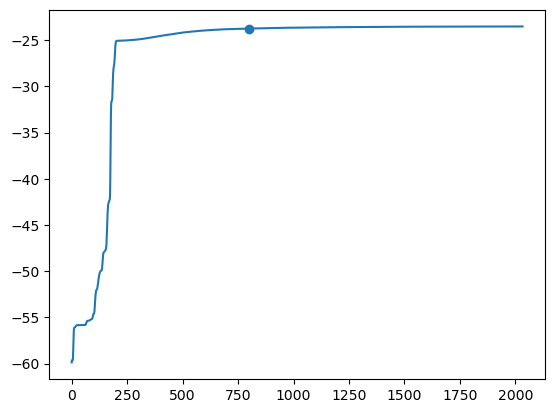

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_8_v_45deg.txt 14.3078756332397
(np.float64(-2.0564261429231494),           range  sigma_log
0      0.507055  -6.039556
1      0.525792  -6.020638
2      0.544529  -6.019977
3      0.563267  -6.019915
4      0.582004  -6.019908
...         ...        ...
2028  38.505749  -2.037928
2029  38.524487  -2.037926
2030  38.543224  -2.037925
2031  38.561961  -2.037923
2032  38.580698  -2.037922

[2033 rows x 2 columns])


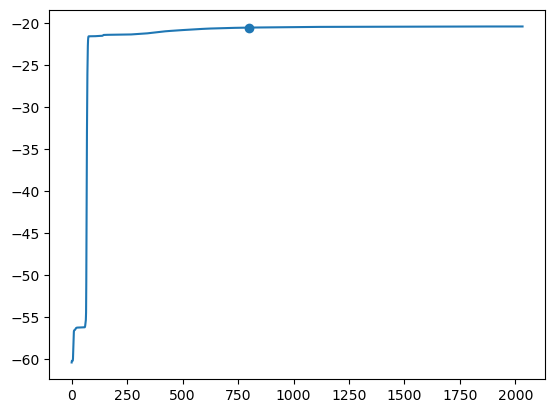

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_2_v_15deg.txt 6.17869091033936
(np.float64(-0.7468696927777704),           range  sigma_log
0      0.507055  -5.895229
1      0.525792  -5.873937
2      0.544529  -5.873139
3      0.563267  -5.873084
4      0.582004  -5.873021
...         ...        ...
2028  38.505749  -0.743515
2029  38.524487  -0.743515
2030  38.543224  -0.743515
2031  38.561961  -0.743515
2032  38.580698  -0.743515

[2033 rows x 2 columns])


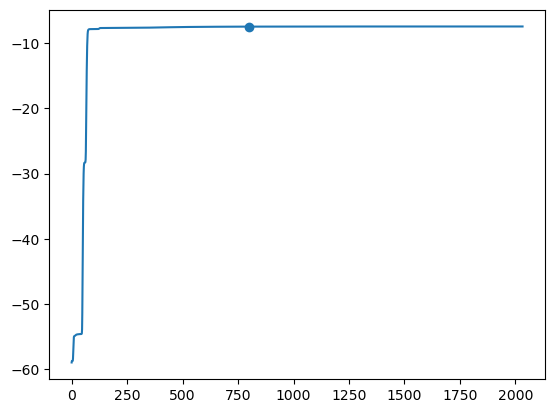

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_7_v_0deg.txt 16.1153011322021
(np.float64(-1.8089018701056894),           range  sigma_log
0      0.507055  -5.909919
1      0.525792  -5.884861
2      0.544529  -5.883495
3      0.563267  -5.883396
4      0.582004  -5.883376
...         ...        ...
2028  38.505749  -1.797195
2029  38.524487  -1.797194
2030  38.543224  -1.797194
2031  38.561961  -1.797193
2032  38.580698  -1.797192

[2033 rows x 2 columns])


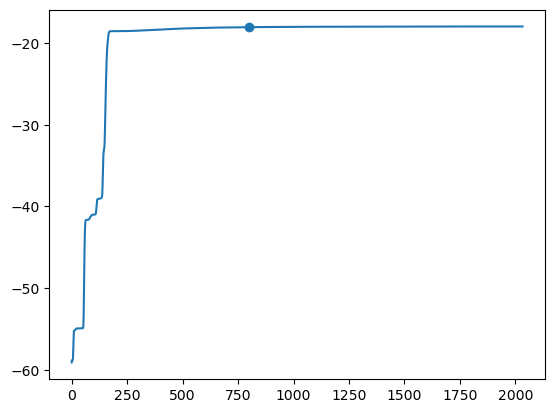

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_3_v_-30deg.txt 9.85938739776611
(np.float64(-2.4405195864655505),           range  sigma_log
0      0.507055  -5.981695
1      0.525792  -5.957738
2      0.544529  -5.956666
3      0.563267  -5.956605
4      0.582004  -5.956530
...         ...        ...
2028  38.505749  -2.408786
2029  38.524487  -2.408782
2030  38.543224  -2.408779
2031  38.561961  -2.408776
2032  38.580698  -2.408773

[2033 rows x 2 columns])


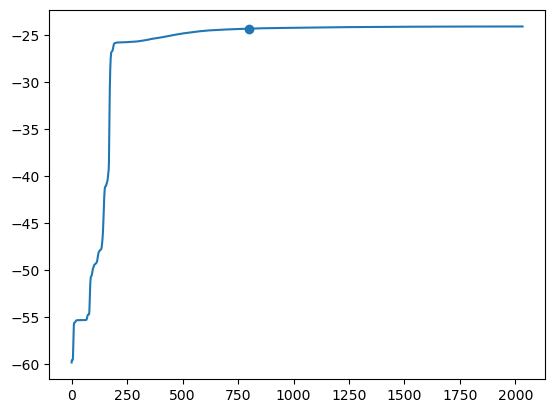

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_8_v_-15deg.txt 14.3078756332397
(np.float64(-2.090766500390813),           range  sigma_log
0      0.507055  -5.955065
1      0.525792  -5.930469
2      0.544529  -5.929145
3      0.563267  -5.929041
4      0.582004  -5.929007
...         ...        ...
2028  38.505749  -2.073956
2029  38.524487  -2.073955
2030  38.543224  -2.073954
2031  38.561961  -2.073952
2032  38.580698  -2.073951

[2033 rows x 2 columns])


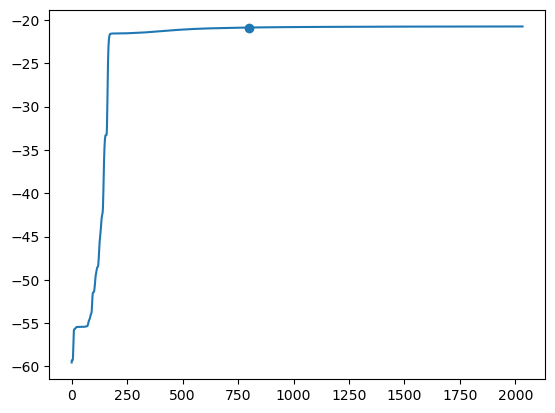

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_1_v_-15deg.txt 4.18170642852783
(np.float64(-1.24230729764229),           range  sigma_log
0      0.507055  -5.898601
1      0.525792  -5.875005
2      0.544529  -5.873846
3      0.563267  -5.873765
4      0.582004  -5.873719
...         ...        ...
2028  38.505749  -1.238404
2029  38.524487  -1.238404
2030  38.543224  -1.238404
2031  38.561961  -1.238404
2032  38.580698  -1.238403

[2033 rows x 2 columns])


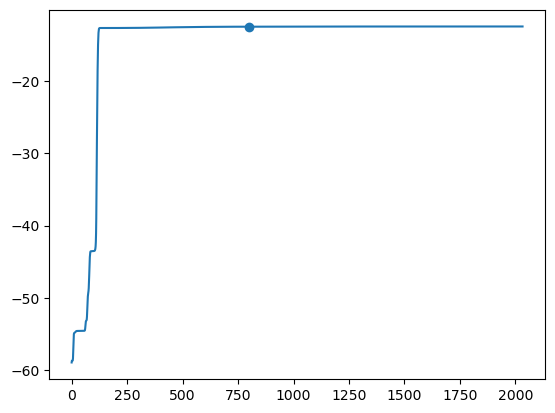

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_6_v_45deg.txt 19.817289352417
(np.float64(-1.803840086557921),           range  sigma_log
0      0.507055  -5.964274
1      0.525792  -5.942610
2      0.544529  -5.941718
3      0.563267  -5.941658
4      0.582004  -5.941635
...         ...        ...
2028  38.505749  -1.793833
2029  38.524487  -1.793832
2030  38.543224  -1.793831
2031  38.561961  -1.793830
2032  38.580698  -1.793829

[2033 rows x 2 columns])


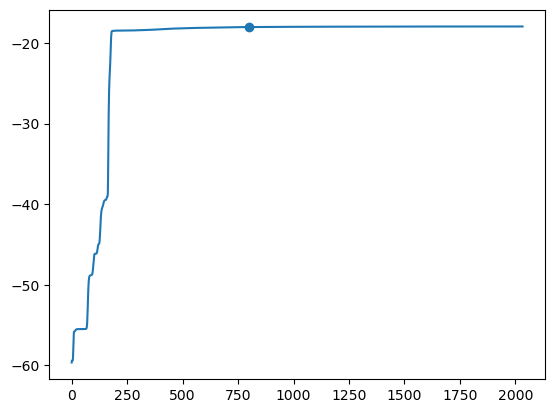

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_6_v_-15deg.txt 19.817289352417
(np.float64(-1.6149359931919944),           range  sigma_log
0      0.507055  -5.982426
1      0.525792  -5.958609
2      0.544529  -5.957322
3      0.563267  -5.957218
4      0.582004  -5.957174
...         ...        ...
2028  38.505749  -1.608104
2029  38.524487  -1.608104
2030  38.543224  -1.608104
2031  38.561961  -1.608103
2032  38.580698  -1.608103

[2033 rows x 2 columns])


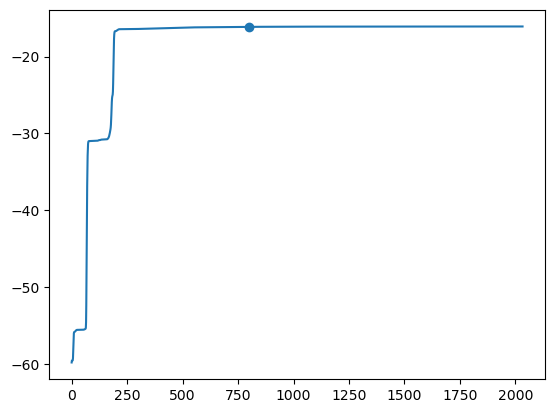

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_9_v_-15deg.txt 13.9201574325562
(np.float64(-2.4037152300400293),           range  sigma_log
0      0.507055  -5.967211
1      0.525792  -5.943351
2      0.544529  -5.942075
3      0.563267  -5.941974
4      0.582004  -5.941952
...         ...        ...
2028  38.505749  -2.371179
2029  38.524487  -2.371177
2030  38.543224  -2.371174
2031  38.561961  -2.371172
2032  38.580698  -2.371169

[2033 rows x 2 columns])


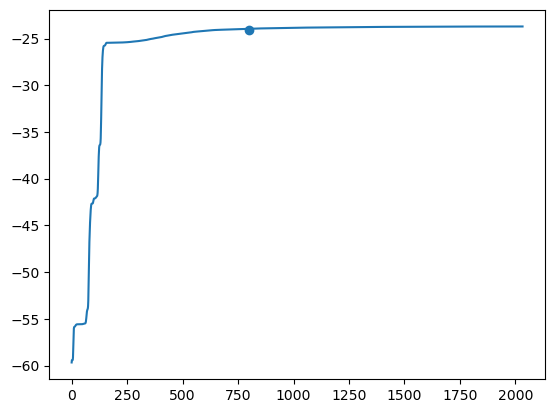

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_2_v_-15deg.txt 6.17869091033936
(np.float64(-1.2523871561794002),           range  sigma_log
0      0.507055  -5.918592
1      0.525792  -5.896125
2      0.544529  -5.895134
3      0.563267  -5.895065
4      0.582004  -5.895023
...         ...        ...
2028  38.505749  -1.249055
2029  38.524487  -1.249054
2030  38.543224  -1.249054
2031  38.561961  -1.249054
2032  38.580698  -1.249054

[2033 rows x 2 columns])


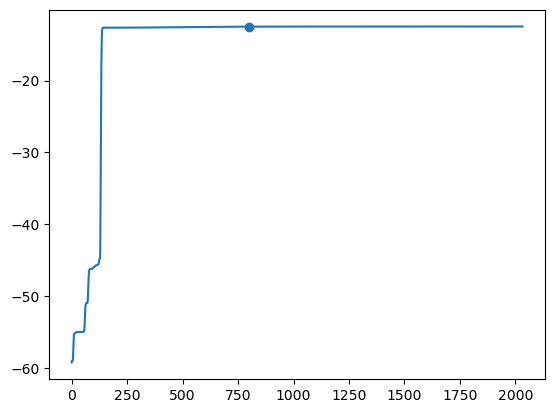

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_3_v_15deg.txt 9.85938739776611
(np.float64(-1.344769370696792),           range  sigma_log
0      0.507055  -5.929482
1      0.525792  -5.911053
2      0.544529  -5.910489
3      0.563267  -5.910439
4      0.582004  -5.910418
...         ...        ...
2028  38.505749  -1.334933
2029  38.524487  -1.334932
2030  38.543224  -1.334932
2031  38.561961  -1.334932
2032  38.580698  -1.334931

[2033 rows x 2 columns])


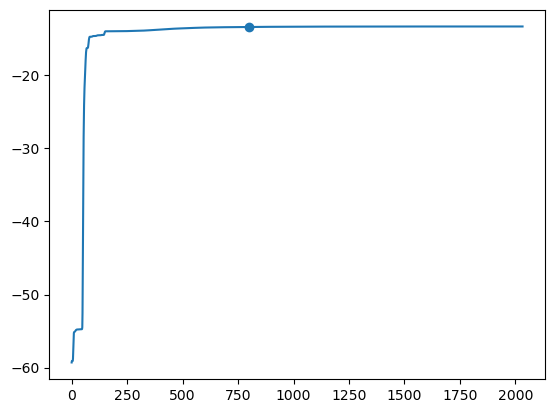

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_4_v_-30deg.txt 14.3579883575439
(np.float64(-2.601349722859625),           range  sigma_log
0      0.507055  -6.080628
1      0.525792  -6.059595
2      0.544529  -6.058753
3      0.563267  -6.058707
4      0.582004  -6.058678
...         ...        ...
2028  38.505749  -2.559494
2029  38.524487  -2.559489
2030  38.543224  -2.559484
2031  38.561961  -2.559479
2032  38.580698  -2.559473

[2033 rows x 2 columns])


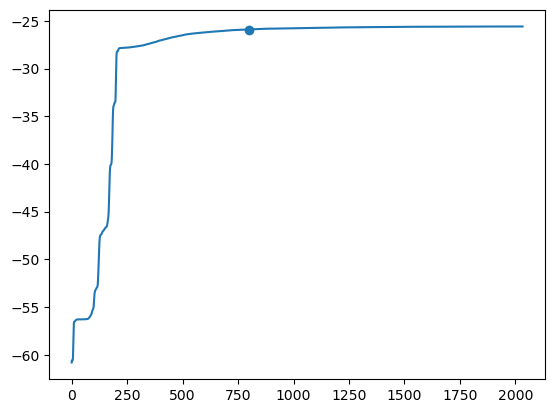

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_7_v_30deg.txt 16.1153011322021
(np.float64(-0.2824223321806124),           range  sigma_log
0      0.507055  -5.913937
1      0.525792  -5.890285
2      0.544529  -5.889144
3      0.563267  -5.889061
4      0.582004  -5.889038
...         ...        ...
2028  38.505749  -0.281156
2029  38.524487  -0.281156
2030  38.543224  -0.281156
2031  38.561961  -0.281156
2032  38.580698  -0.281156

[2033 rows x 2 columns])


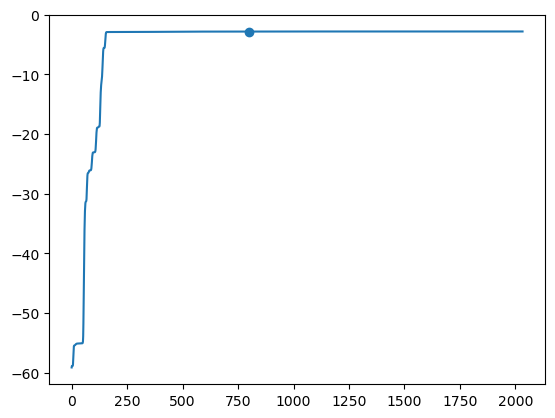

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_7_v_15deg.txt 16.1153011322021
(np.float64(1.492064367019737),           range  sigma_log
0      0.507055  -5.898414
1      0.525792  -5.873030
2      0.544529  -5.871617
3      0.563267  -5.871465
4      0.582004  -5.871411
...         ...        ...
2028  38.505749   1.492224
2029  38.524487   1.492224
2030  38.543224   1.492224
2031  38.561961   1.492224
2032  38.580698   1.492224

[2033 rows x 2 columns])


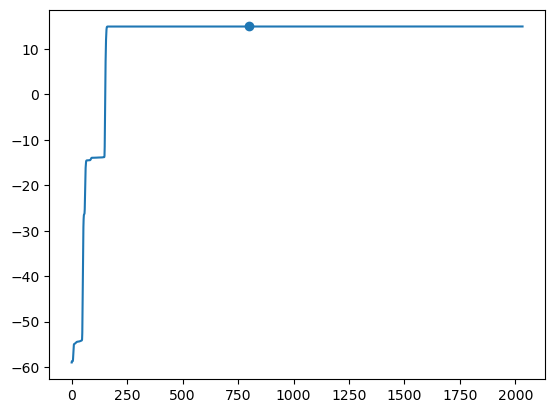

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_6_v_30deg.txt 19.817289352417
(np.float64(-0.5072004114516573),           range  sigma_log
0      0.507055  -5.911378
1      0.525792  -5.887142
2      0.544529  -5.885892
3      0.563267  -5.885804
4      0.582004  -5.885767
...         ...        ...
2028  38.505749  -0.504685
2029  38.524487  -0.504685
2030  38.543224  -0.504685
2031  38.561961  -0.504685
2032  38.580698  -0.504685

[2033 rows x 2 columns])


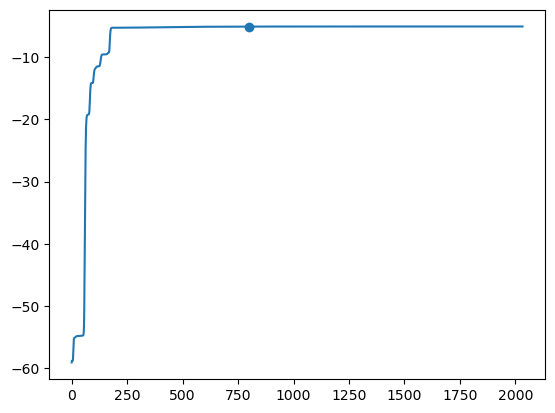

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_7_v_45deg.txt 16.1153011322021
(np.float64(-2.345254565901775),           range  sigma_log
0      0.507055  -5.993394
1      0.525792  -5.971548
2      0.544529  -5.970577
3      0.563267  -5.970509
4      0.582004  -5.970495
...         ...        ...
2028  38.505749  -2.315315
2029  38.524487  -2.315312
2030  38.543224  -2.315309
2031  38.561961  -2.315306
2032  38.580698  -2.315303

[2033 rows x 2 columns])


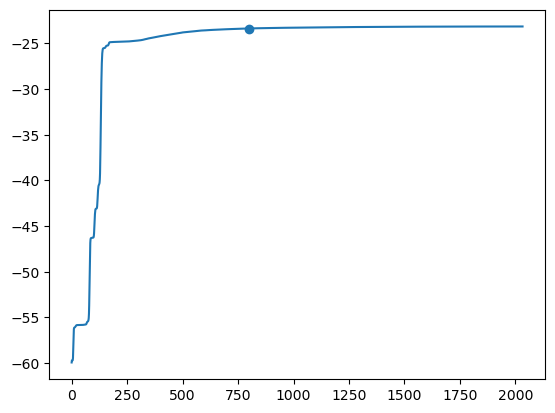

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_3_v_-15deg.txt 9.85938739776611
(np.float64(-2.1761307198745583),           range  sigma_log
0      0.507055  -5.897239
1      0.525792  -5.871840
2      0.544529  -5.870497
3      0.563267  -5.870399
4      0.582004  -5.870316
...         ...        ...
2028  38.505749  -2.154838
2029  38.524487  -2.154836
2030  38.543224  -2.154835
2031  38.561961  -2.154833
2032  38.580698  -2.154831

[2033 rows x 2 columns])


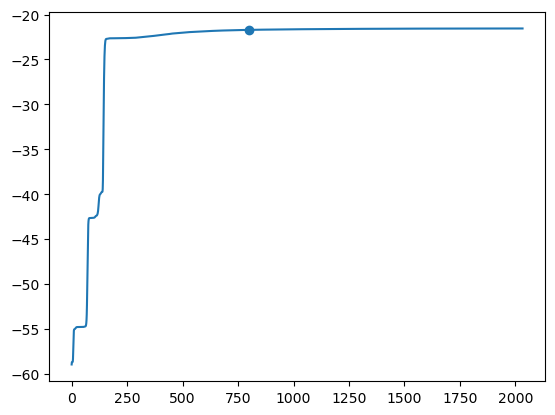

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_9_v_15deg.txt 13.9201574325562
(np.float64(-1.4208803653948976),           range  sigma_log
0      0.507055  -5.967802
1      0.525792  -5.947446
2      0.544529  -5.946605
3      0.563267  -5.946536
4      0.582004  -5.946518
...         ...        ...
2028  38.505749  -1.413972
2029  38.524487  -1.413972
2030  38.543224  -1.413972
2031  38.561961  -1.413971
2032  38.580698  -1.413971

[2033 rows x 2 columns])


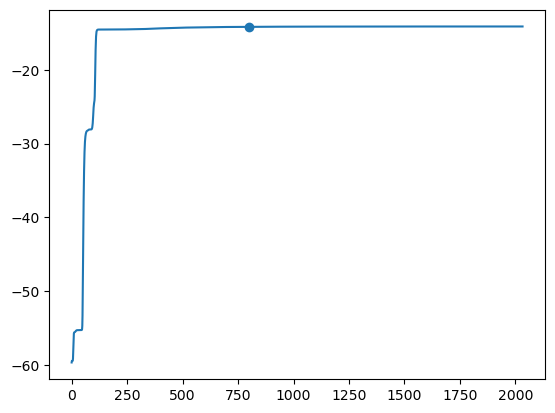

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_4_v_30deg.txt 14.3579883575439
(np.float64(-1.1271277709234737),           range  sigma_log
0      0.507055  -5.982716
1      0.525792  -5.963279
2      0.544529  -5.962605
3      0.563267  -5.962560
4      0.582004  -5.962547
...         ...        ...
2028  38.505749  -1.124460
2029  38.524487  -1.124460
2030  38.543224  -1.124459
2031  38.561961  -1.124459
2032  38.580698  -1.124459

[2033 rows x 2 columns])


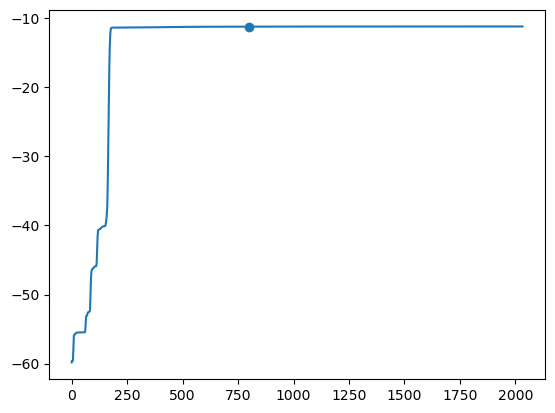

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_9_v_45deg.txt 13.9201574325562
(np.float64(-2.651399061411633),           range  sigma_log
0      0.507055  -6.026527
1      0.525792  -6.007115
2      0.544529  -6.006422
3      0.563267  -6.006370
4      0.582004  -6.006359
...         ...        ...
2028  38.505749  -2.595967
2029  38.524487  -2.595962
2030  38.543224  -2.595958
2031  38.561961  -2.595955
2032  38.580698  -2.595952

[2033 rows x 2 columns])


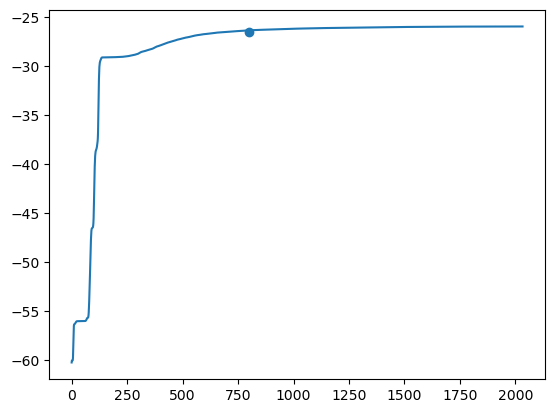

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_3_v_0deg.txt 9.85938739776611
(np.float64(-1.7432542710874028),           range  sigma_log
0      0.507055  -5.896708
1      0.525792  -5.875902
2      0.544529  -5.875236
3      0.563267  -5.875202
4      0.582004  -5.875177
...         ...        ...
2028  38.505749  -1.729111
2029  38.524487  -1.729110
2030  38.543224  -1.729109
2031  38.561961  -1.729108
2032  38.580698  -1.729108

[2033 rows x 2 columns])


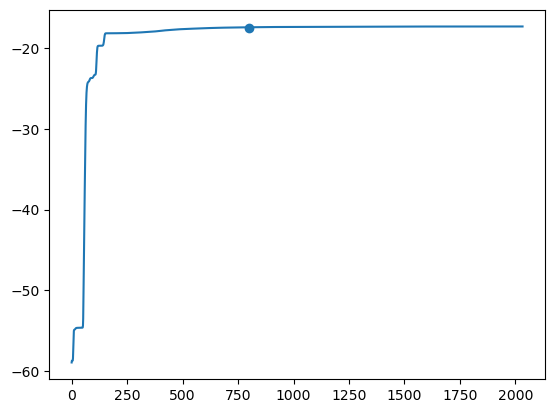

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_8_v_0deg.txt 14.3078756332397
(np.float64(-2.2563045267062414),           range  sigma_log
0      0.507055  -5.973085
1      0.525792  -5.952664
2      0.544529  -5.951850
3      0.563267  -5.951787
4      0.582004  -5.951770
...         ...        ...
2028  38.505749  -2.222942
2029  38.524487  -2.222941
2030  38.543224  -2.222939
2031  38.561961  -2.222938
2032  38.580698  -2.222936

[2033 rows x 2 columns])


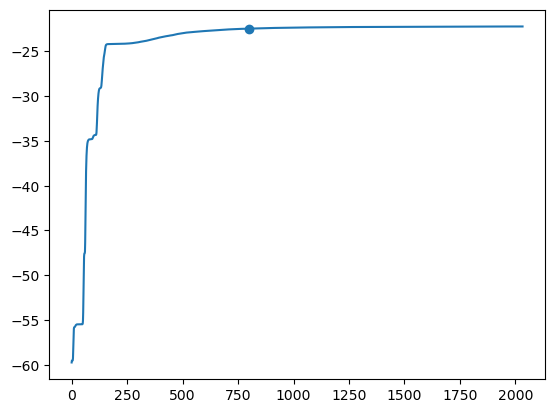

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_5_v_-15deg.txt 20.7384872436523
(np.float64(-2.6025126079800702),           range  sigma_log
0      0.507055  -6.018589
1      0.525792  -5.997100
2      0.544529  -5.996168
3      0.563267  -5.996102
4      0.582004  -5.996086
...         ...        ...
2028  38.505749  -2.555994
2029  38.524487  -2.555991
2030  38.543224  -2.555989
2031  38.561961  -2.555986
2032  38.580698  -2.555984

[2033 rows x 2 columns])


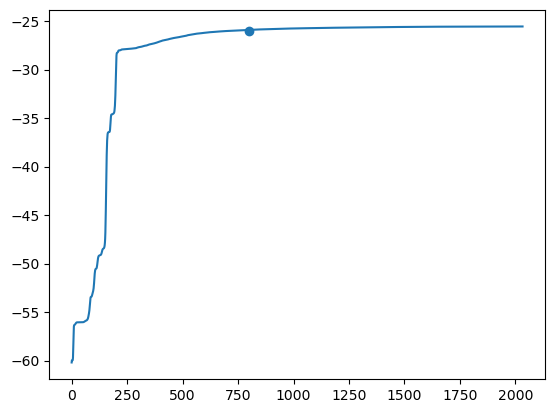

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_4_v_-15deg.txt 14.3579883575439
(np.float64(-2.022655229137538),           range  sigma_log
0      0.507055  -5.963273
1      0.525792  -5.939782
2      0.544529  -5.938587
3      0.563267  -5.938496
4      0.582004  -5.938459
...         ...        ...
2028  38.505749  -2.007596
2029  38.524487  -2.007594
2030  38.543224  -2.007593
2031  38.561961  -2.007591
2032  38.580698  -2.007590

[2033 rows x 2 columns])


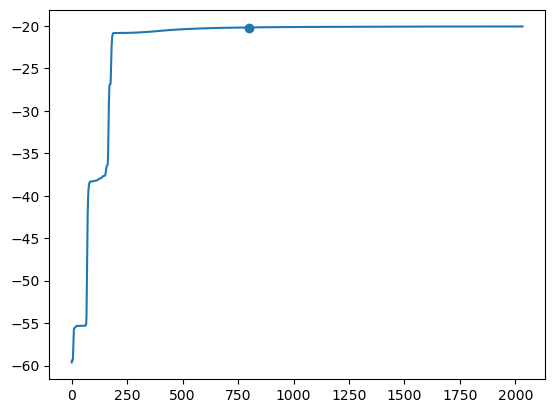

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_1_v_30deg.txt 4.18170642852783
(np.float64(-2.5790775189667046),           range  sigma_log
0      0.507055  -5.916679
1      0.525792  -5.894607
2      0.544529  -5.893817
3      0.563267  -5.893784
4      0.582004  -5.893727
...         ...        ...
2028  38.505749  -2.529195
2029  38.524487  -2.529190
2030  38.543224  -2.529185
2031  38.561961  -2.529181
2032  38.580698  -2.529176

[2033 rows x 2 columns])


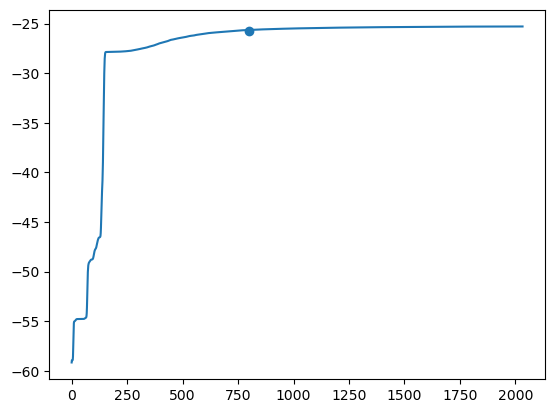

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_5_v_0deg.txt 20.7384872436523
(np.float64(-0.4294844185934784),           range  sigma_log
0      0.507055  -5.956072
1      0.525792  -5.934991
2      0.544529  -5.934188
3      0.563267  -5.934141
4      0.582004  -5.934122
...         ...        ...
2028  38.505749  -0.428344
2029  38.524487  -0.428344
2030  38.543224  -0.428344
2031  38.561961  -0.428344
2032  38.580698  -0.428344

[2033 rows x 2 columns])


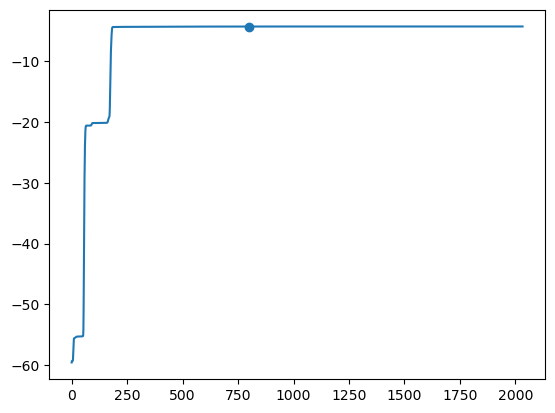

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_1_v_15deg.txt 4.18170642852783
(np.float64(-2.103466911345877),           range  sigma_log
0      0.507055  -5.887197
1      0.525792  -5.865563
2      0.544529  -5.864693
3      0.563267  -5.864645
4      0.582004  -5.864560
...         ...        ...
2028  38.505749  -2.077367
2029  38.524487  -2.077366
2030  38.543224  -2.077364
2031  38.561961  -2.077363
2032  38.580698  -2.077361

[2033 rows x 2 columns])


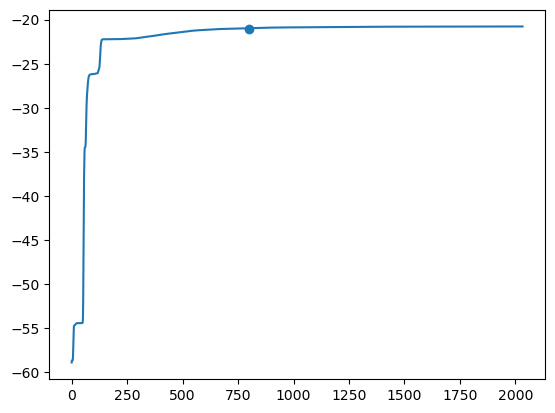

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_4_v_0deg.txt 14.3579883575439
(np.float64(-1.187993299712659),           range  sigma_log
0      0.507055  -5.950075
1      0.525792  -5.928342
2      0.544529  -5.927249
3      0.563267  -5.927152
4      0.582004  -5.927131
...         ...        ...
2028  38.505749  -1.183714
2029  38.524487  -1.183713
2030  38.543224  -1.183713
2031  38.561961  -1.183713
2032  38.580698  -1.183713

[2033 rows x 2 columns])


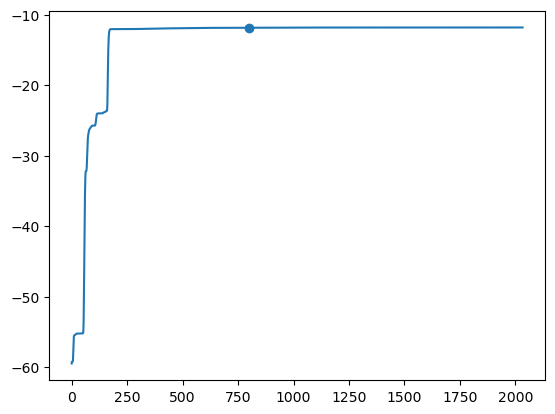

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_9_v_0deg.txt 13.9201574325562
(np.float64(-1.7761275289395821),           range  sigma_log
0      0.507055  -5.947754
1      0.525792  -5.926012
2      0.544529  -5.925014
3      0.563267  -5.924940
4      0.582004  -5.924919
...         ...        ...
2028  38.505749  -1.763039
2029  38.524487  -1.763038
2030  38.543224  -1.763037
2031  38.561961  -1.763037
2032  38.580698  -1.763036

[2033 rows x 2 columns])


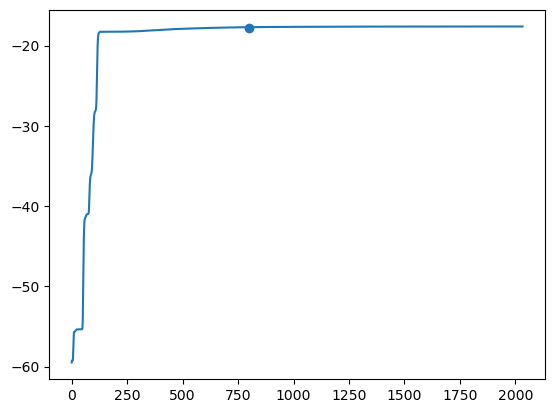

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_9_v_30deg.txt 13.9201574325562
(np.float64(-1.5013483480699146),           range  sigma_log
0      0.507055  -5.971183
1      0.525792  -5.950606
2      0.544529  -5.949806
3      0.563267  -5.949751
4      0.582004  -5.949736
...         ...        ...
2028  38.505749  -1.493756
2029  38.524487  -1.493755
2030  38.543224  -1.493755
2031  38.561961  -1.493754
2032  38.580698  -1.493754

[2033 rows x 2 columns])


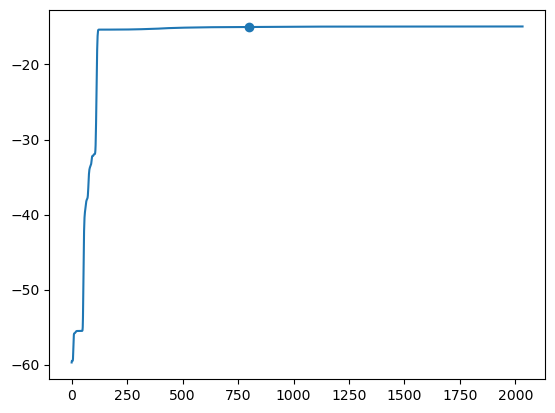

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_6_v_0deg.txt 19.817289352417
(np.float64(-1.099115409760742),           range  sigma_log
0      0.507055  -5.918651
1      0.525792  -5.895735
2      0.544529  -5.894571
3      0.563267  -5.894463
4      0.582004  -5.894425
...         ...        ...
2028  38.505749  -1.095049
2029  38.524487  -1.095048
2030  38.543224  -1.095048
2031  38.561961  -1.095048
2032  38.580698  -1.095048

[2033 rows x 2 columns])


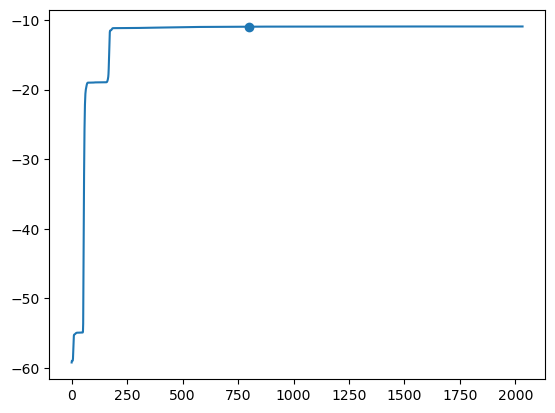

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_6_v_15deg.txt 19.817289352417
(np.float64(0.5054692560929432),           range  sigma_log
0      0.507055  -5.914023
1      0.525792  -5.889519
2      0.544529  -5.888143
3      0.563267  -5.888023
4      0.582004  -5.887988
...         ...        ...
2028  38.505749   0.506350
2029  38.524487   0.506350
2030  38.543224   0.506350
2031  38.561961   0.506350
2032  38.580698   0.506350

[2033 rows x 2 columns])


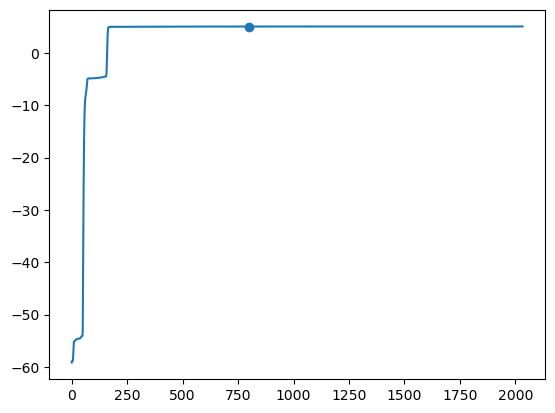

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_5_v_45deg.txt 20.7384872436523
(np.float64(-2.1710936210187546),           range  sigma_log
0      0.507055  -5.973875
1      0.525792  -5.952354
2      0.544529  -5.951444
3      0.563267  -5.951382
4      0.582004  -5.951366
...         ...        ...
2028  38.505749  -2.151098
2029  38.524487  -2.151096
2030  38.543224  -2.151094
2031  38.561961  -2.151093
2032  38.580698  -2.151092

[2033 rows x 2 columns])


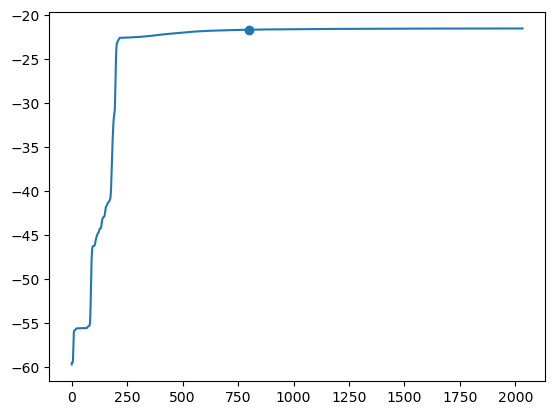

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_2_v_0deg.txt 6.17869091033936
(np.float64(-1.3333615616976233),           range  sigma_log
0      0.507055  -5.904869
1      0.525792  -5.882602
2      0.544529  -5.881592
3      0.563267  -5.881522
4      0.582004  -5.881471
...         ...        ...
2028  38.505749  -1.325867
2029  38.524487  -1.325867
2030  38.543224  -1.325867
2031  38.561961  -1.325866
2032  38.580698  -1.325866

[2033 rows x 2 columns])


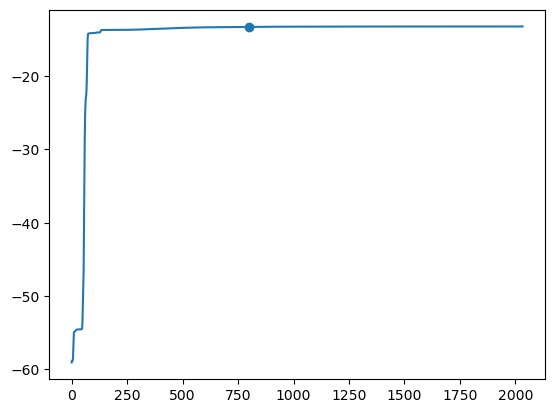

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_1_v_0deg.txt 4.18170642852783
(np.float64(-1.008476360705164),           range  sigma_log
0      0.507055  -5.879067
1      0.525792  -5.858250
2      0.544529  -5.857452
3      0.563267  -5.857390
4      0.582004  -5.857287
...         ...        ...
2028  38.505749  -1.002320
2029  38.524487  -1.002320
2030  38.543224  -1.002319
2031  38.561961  -1.002319
2032  38.580698  -1.002319

[2033 rows x 2 columns])


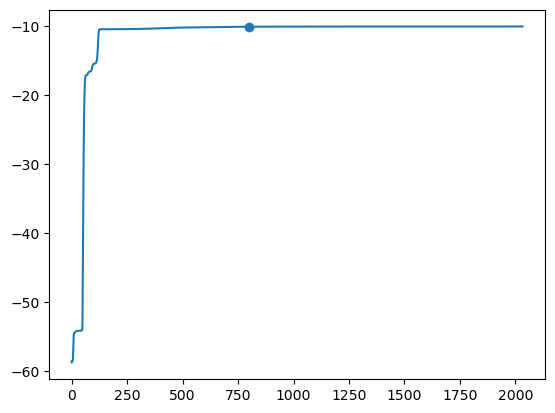

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_5_v_30deg.txt 20.7384872436523
(np.float64(-1.6474628385673706),           range  sigma_log
0      0.507055  -5.943581
1      0.525792  -5.921740
2      0.544529  -5.920782
3      0.563267  -5.920710
4      0.582004  -5.920700
...         ...        ...
2028  38.505749  -1.637125
2029  38.524487  -1.637124
2030  38.543224  -1.637123
2031  38.561961  -1.637122
2032  38.580698  -1.637121

[2033 rows x 2 columns])


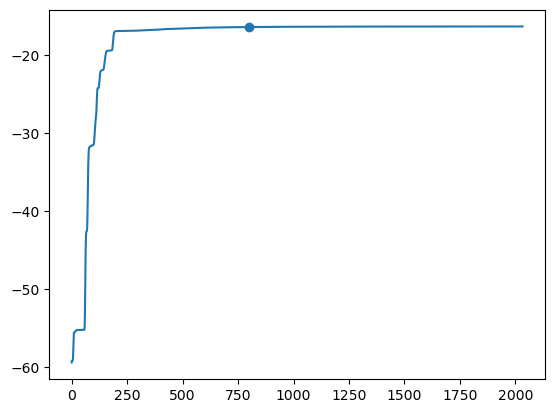

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_2_v_-30deg.txt 6.17869091033936
(np.float64(-2.8761541571374956),           range  sigma_log
0      0.507055  -5.986038
1      0.525792  -5.964130
2      0.544529  -5.963236
3      0.563267  -5.963179
4      0.582004  -5.963132
...         ...        ...
2028  38.505749  -2.794027
2029  38.524487  -2.794021
2030  38.543224  -2.794015
2031  38.561961  -2.794009
2032  38.580698  -2.794002

[2033 rows x 2 columns])


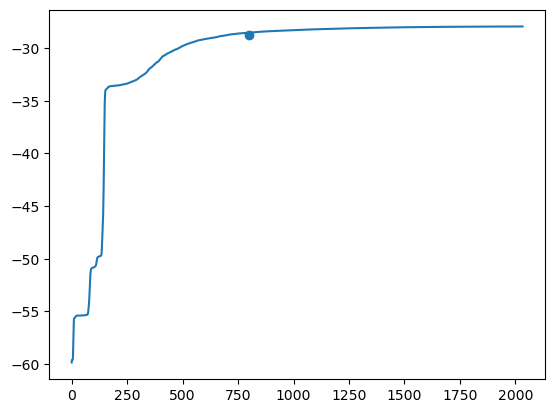

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_5_v_15deg.txt 20.7384872436523
(np.float64(-0.6341575745169297),           range  sigma_log
0      0.507055  -5.912378
1      0.525792  -5.889844
2      0.544529  -5.888902
3      0.563267  -5.888847
4      0.582004  -5.888823
...         ...        ...
2028  38.505749  -0.631336
2029  38.524487  -0.631336
2030  38.543224  -0.631336
2031  38.561961  -0.631335
2032  38.580698  -0.631335

[2033 rows x 2 columns])


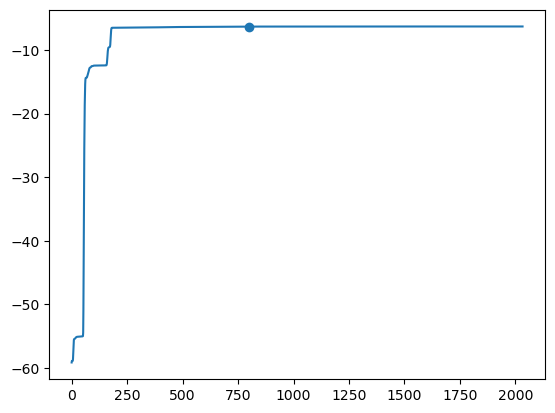

/home/nicolas/Documents/Dku-toolbox/data/untest/17GHz_fortress_drift_4_v_45deg.txt 14.3579883575439
(np.float64(-2.1844926613118725),           range  sigma_log
0      0.507055  -6.007992
1      0.525792  -5.987627
2      0.544529  -5.986835
3      0.563267  -5.986782
4      0.582004  -5.986770
...         ...        ...
2028  38.505749  -2.164606
2029  38.524487  -2.164604
2030  38.543224  -2.164602
2031  38.561961  -2.164600
2032  38.580698  -2.164598

[2033 rows x 2 columns])


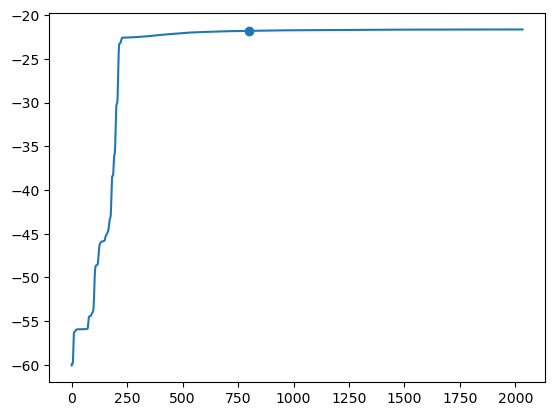

In [6]:
s13 = []
s17 = []

for i in mesures[:]:  
    print(i.filepath,i.pente)     
    if i.frequence == 17:
        sigma = get_sigma0(i,c17)
        siigma = RadarMesure.get_sigma0(i,c17)
        s17.append(sigma)

    if i.frequence == 13:
        sigma = get_sigma0(i,c13)
        RadarMesure.get_sigma0(i,c13)
        s13.append(sigma)
    
    plt.plot(range(len(sigma['range'])),10*sigma['sigma_log'])
    plt.scatter(200*i.pad_factor,10*siigma[0])
    print(siigma)
    #plt.title(i.filepath)
    plt.show()


In [ ]:
mesures

In [ ]:
mesures[0].filepath

'/home/nicolas/Documents/data/radar/to_sort/fm_2024_dec/01_12/13GHz_Fortress-Ridge-Met-Deeper-Snow_1_v_30deg.txt'